# Tutorial for using `align_represenatations.py` 

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../'))

import numpy as np
import pandas as pd
import pickle as pkl
from src.align_representations import Representation, AlignRepresentations, OptimizationConfig, VisualizationConfig
from src.utils.utils_functions import get_category_data

## Load data
you can choose the following data
1. 'DNN': representations of 2000 imagenet images in AlexNet and VGG19
1. 'color': human similarity judgements of 93 colors for 5 paricipants groups
1. 'face': human similarity judgements of 16 faces, attended vs unattended condition in the same participant
1. 'THINGS' : human similarity judgements of 1854 objects for 4 paricipants groups



In [2]:
data_select = "THINGS"

'''
Set Representations
    - A Representation needs a name and either an embedding or a similarity matrix.
'''
# Parameters
n_representations = 4 # Set the number of representations. This number must be equal to or less than the number of groups.
metric = "euclidean"

# representations list that will be used in Align_Representations
representations = list()

# Load data and create representations instance
if data_select == 'color':
    data_path = '../data/num_groups_5_seed_0_fill_val_3.5.pickle'
    with open(data_path, "rb") as f:
        data = pkl.load(f)
    sim_mat_list = data["group_ave_mat"]
    for i in range(n_representations):
        name = f"Group{i+1}"
        sim_mat = sim_mat_list[i]
        representation = Representation(name = name, sim_mat = sim_mat)
        representations.append(representation)

elif data_select == "THINGS":
    category_mat = pd.read_csv("../data/category_mat_manual_preprocessed.csv", sep = ",", index_col = 0)  
    
    for i in range(n_representations):
        name = f"Group{i+1}"
        embedding = np.load(f"../data/THINGS_embedding_Group{i+1}.npy")[0]
        representation = Representation(name = name, embedding = embedding, metric = metric, category_mat = category_mat)
        representations.append(representation)

## Set the parameters for the optimazation of GWOT, and the parameters for visualizing matrices

In [3]:

config = OptimizationConfig(
    data_name = data_select, 
    delete_study = False, 
    device = 'cpu',
    to_types = 'numpy',
    n_jobs = 1,
    init_plans_list = ['random'],
    num_trial = 4,
    n_iter = 1,
    max_iter = 200,
    sampler_name = 'tpe',
    eps_list = [1, 10], # [1, 10] for THINGS data, [0.02, 0.2] for colors data
    eps_log = True,
    pruner_name = 'hyperband',
    pruner_params = {'n_startup_trials': 1, 
                     'n_warmup_steps': 2, 
                     'min_resource': 2, 
                     'reduction_factor' : 3
                    }
)

visualize_matrix = VisualizationConfig(figsize=(8,6), title_size = 15)

## Unsupervised alignment between Representations
    - The object has methods for RSA, GW-alignment, evaluation of the alignment and visalization of aligned embeddings.
    - The parameter "shuffle" means a method is applied for a shuffled similarity matrix.

Pair number 0 : Group1 vs Group2
Pair number 1 : Group1 vs Group3
Pair number 2 : Group1 vs Group4
Pair number 3 : Group2 vs Group3
Pair number 4 : Group2 vs Group4
Pair number 5 : Group3 vs Group4


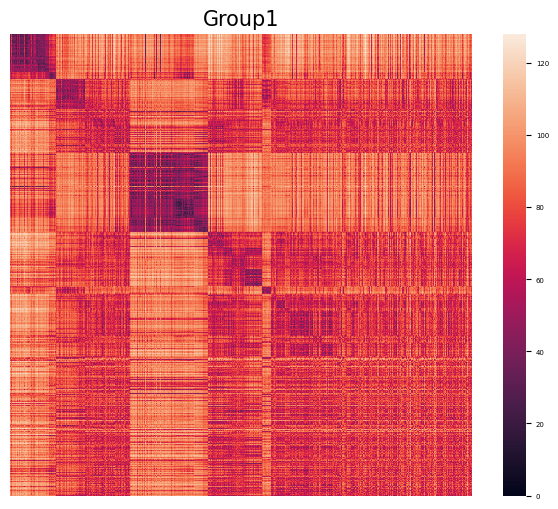

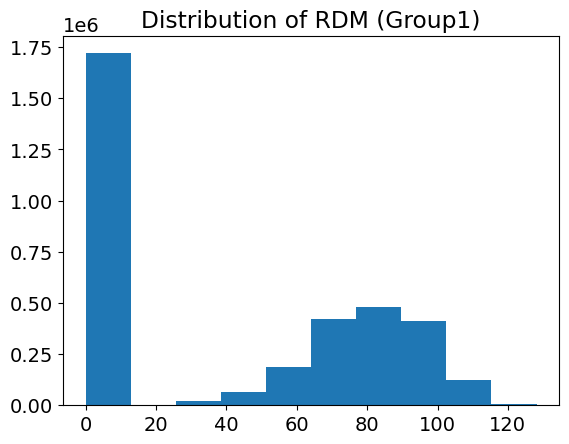

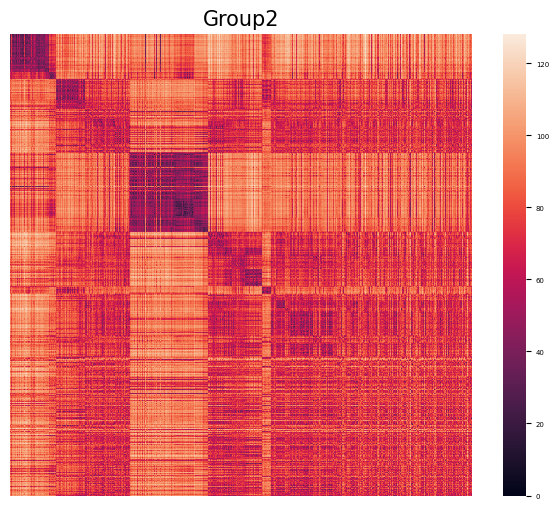

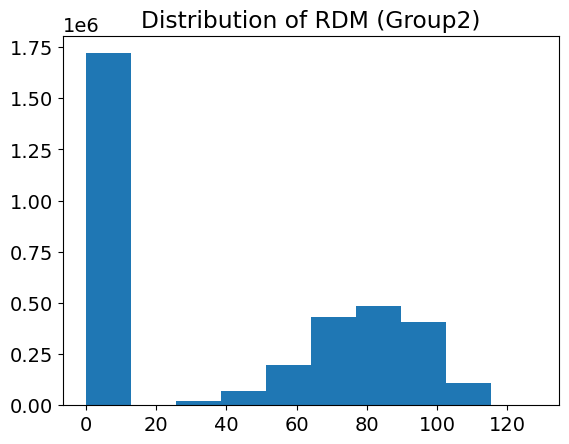

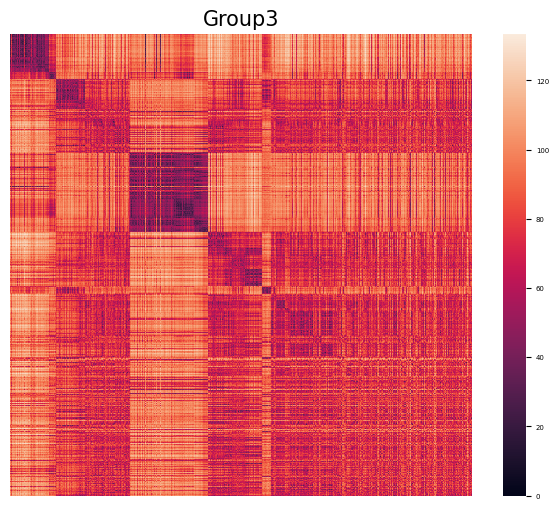

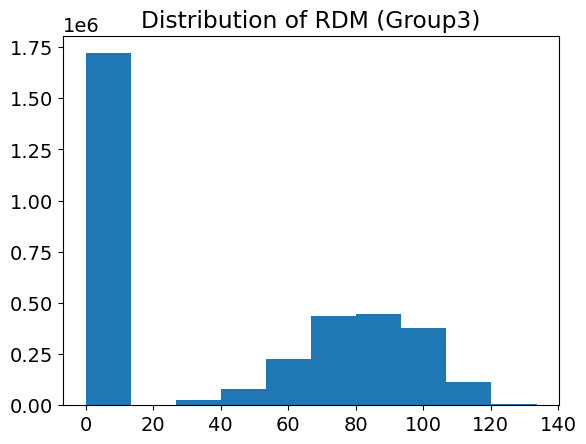

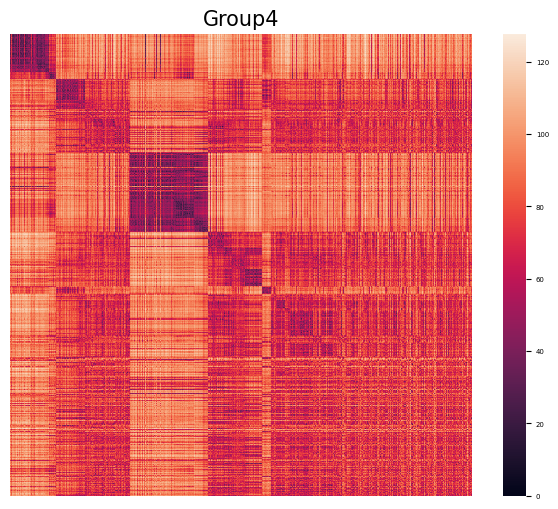

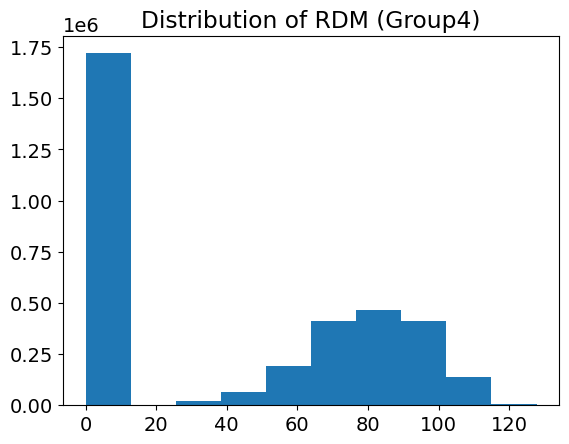

Correlation Group1 vs Group2 : 0.9716248509759134
Correlation Group1 vs Group3 : 0.9729106672988249
Correlation Group1 vs Group4 : 0.971293734817074
Correlation Group2 vs Group3 : 0.9727137456292158
Correlation Group2 vs Group4 : 0.97202160614847
Correlation Group3 vs Group4 : 0.9736576887900769


In [4]:
# Set the instance
align_representation = AlignRepresentations(representations_list = representations, config = config)

# RSA
sim_mat = align_representation.show_sim_mat(returned = "figure", sim_mat_format = "sorted", visualization_config = visualize_matrix)#fig_dir = "../figures")
align_representation.RSA_get_corr()

## Computing GW Alignment in the next block.

Top k accuracy : 
        Group1 vs Group2  Group1 vs Group3  Group1 vs Group4  Group2 vs Group3  \
top_n                                                                           
1             89.697950         88.187702         86.515642         88.295577   
5             96.979504         96.278317         96.548004         96.601942   
10            98.759439         98.381877         98.220065         98.274002   

       Group2 vs Group4  Group3 vs Group4  
top_n                                      
1             89.805825         87.486516  
5             96.440129         95.900755  
10            98.058252         98.220065  
Mean : 
 top_n
1     88.058252
5     96.353830
10    98.230852
dtype: float64


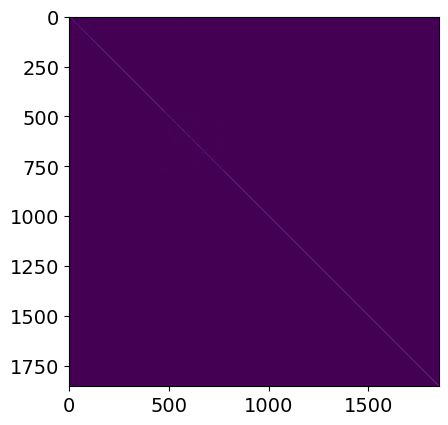

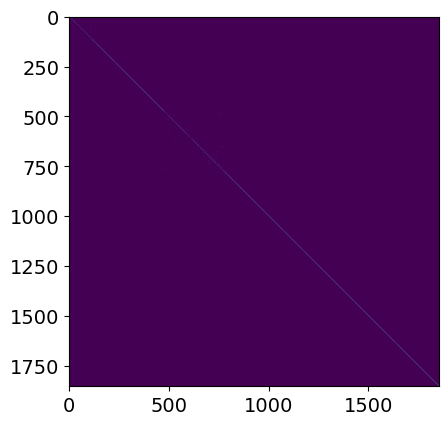

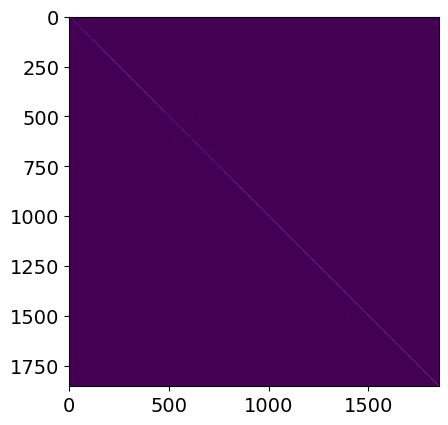

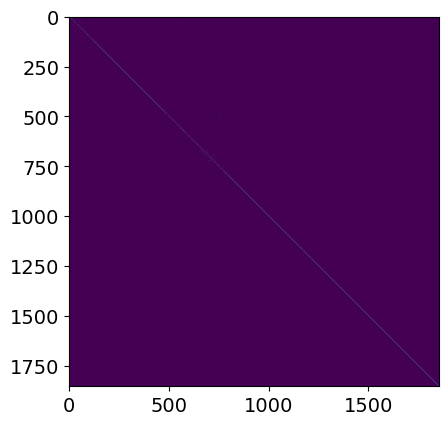

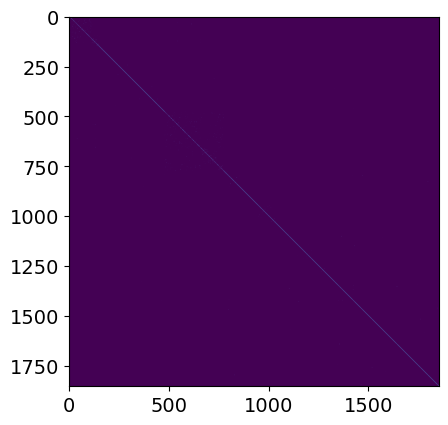

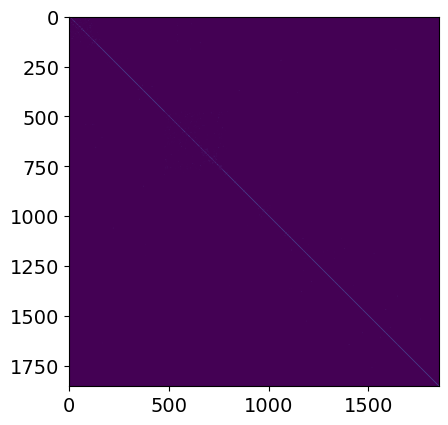

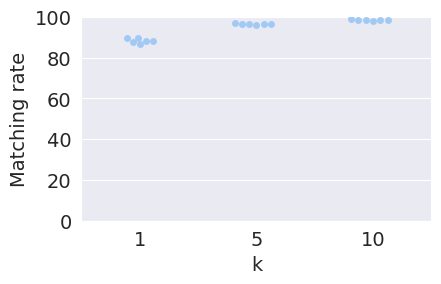

Group1 vs Group2 :  97.0873786407767
Group1 vs Group3 :  96.81769147788565
Group1 vs Group4 :  96.65587918015103
Group2 vs Group3 :  97.46494066882417
Group2 vs Group4 :  97.30312837108953
Group3 vs Group4 :  96.87162891046385


In [5]:
## If no need for computation, turn load_OT True, then OT plans calculated before is loaded.
align_representation.gw_alignment(
    results_dir = "../results",
    returned = "row_data",
    OT_format = "sorted", 
    visualization_config = visualize_matrix
)

## Calculate the accuracy of the optimized OT matrix
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "ot_plan")
align_representation.plot_accuracy(eval_type = "ot_plan", scatter = True)

## Calclate the category level accuracy
align_representation.calc_category_level_accuracy()

## Align embeddings with OT plans and Visualize the aligned embeddings

K nearest matching rate : 
        Group1 vs Group2  Group1 vs Group3  Group1 vs Group4  Group2 vs Group3  \
top_n                                                                           
1             76.375405         77.669903         77.723840         78.317152   
5             93.365696         93.581446         94.012945         93.851133   
10            96.925566         96.494067         96.601942         96.871629   

       Group2 vs Group4  Group3 vs Group4  
top_n                                      
1             78.694714         75.350593  
5             93.905070         92.664509  
10            96.871629         96.116505  
Mean : 
 top_n
1     77.551241
5     93.603020
10    96.591154
dtype: float64


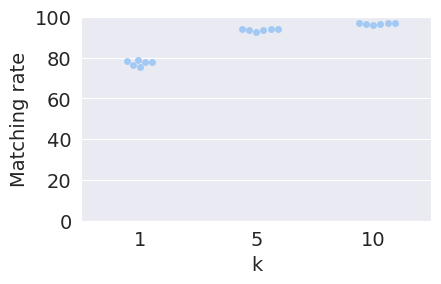

           Number
bird           25
insect         17
plant          28
clothing       82
furniture      33
fruit          33
drink          19
vehicle        67


TypeError: AlignRepresentations.visualize_embedding() got an unexpected keyword argument 'category_num_list'

In [6]:

## Calculate the matching rate of k-nearest neighbors of embeddings
## Matching rate of k-nearest neighbors 
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "k_nearest")
align_representation.plot_accuracy(eval_type = "k_nearest", scatter = True)


# Set color labels and category data if exist.
if data_select == "THINGS":
    color_labels = None
    category_name_list = ["bird", "insect", "plant", "clothing",  "furniture", "fruit", "drink", "vehicle"]
    category_mat = pd.read_csv("../data/category_mat_manual_preprocessed.csv", sep = ",", index_col = 0)   
    object_labels, category_idx_list, category_num_list, new_category_name_list = get_category_data(category_mat, category_name_list, show_numbers = True)  
    
    align_representation.visualize_embedding(
        dim = 3,  
        category_name_list = category_name_list, 
        category_idx_list = category_idx_list, 
        category_num_list = category_num_list
    )
